In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, ticker, colors
from scipy.fft import fft # For the fourier transform
from scipy.interpolate import griddata # For the interpolation
from scipy.optimize import curve_fit
from scipy import signal
import scipy.stats as stats
import pandas as pd
import glob

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [247]:
def load_wli_data(path):
    
    data_df = pd.read_csv(path, delimiter=' ', skiprows=14, usecols=[0, 1, 2], skipfooter=1, engine='python')

    data_df = data_df.replace('No', np.nan)

    data_df.astype(float, errors='ignore')

    print(data_df)
    
    data = pd.DataFrame.to_numpy(data_df).T

    return data

def grid_wli(raw_data, resolution):

    x_list = raw_data[0].astype(int)
    y_list = raw_data[1].astype(int)
    z_list = raw_data[2].astype(float)
    z_list = z_list - np.nanmin(z_list) 

    # x_list = abs(x_list - max(x_list))
    y_list = abs(y_list - max(y_list))

    # convert to numpy arrays
    x_list = np.array(x_list)
    y_list = np.array(y_list)
    z_list = np.array(z_list)

    for i in range(max([len(x_list), len(y_list)])):
        if i < len(x_list):
            x_list[i] = resolution * x_list[i]
        if i < len(y_list):
            y_list[i] = resolution * y_list[i]

    print(x_list, y_list, z_list)

    # use scipy.binned_statistic2d to bin the data for plotting, averaging over 1x1 pixels as a bin
    bin_size = resolution
    x_bins = np.arange(0, max(x_list), bin_size)
    y_bins = np.arange(0, max(y_list), bin_size)
    x_bins = np.append(x_bins, max(x_list))
    y_bins = np.append(y_bins, max(y_list))

    print(x_bins, y_bins)

    # bin data
    bin_means, x_edges, y_edges, binnumber = stats.binned_statistic_2d(x_list, y_list, z_list, statistic='mean', bins=[x_bins, y_bins])

    # create meshgrid for plotting
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)

    # plot data, filling in NaN values with interpolation
    fig, ax = plt.subplots()

    # set the figure size by x / y length
    width_multiplier = max(x_list) / max(y_list)
    fig.set_figwidth(width_multiplier * fig.get_figheight())

    # set axis aspect ratio to 1
    # ax.set_aspect('equal')

    # plot with log colorbar , norm=colors.LogNorm(), vmin=1e-3, vmax=1e-1
    cs = ax.contourf(X, Y, bin_means.T, levels=100, cmap='jet')
    cbar = fig.colorbar(cs)
    cbar.set_label('Microns')
    plt.xlabel('Microns')
    plt.ylabel('Microns')
    # Ticks every 1000 microns
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
    
    # transparent background
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    # remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()

    return bin_means, x_edges, y_edges


def combined_save(path):

    data_df = pd.read_csv(path, delimiter=' ', skiprows=14, usecols=[0, 1, 2], skipfooter=1, engine='python')

    data_df = data_df.replace('No', np.nan)

    data_df.astype(float, errors='ignore')

    data = pd.DataFrame.to_numpy(data_df).T

    x_list = data[0].astype(int)
    y_list = data[1].astype(int)
    z_list = data[2].astype(float)
    z_list = z_list - np.nanmin(z_list) 

    y_list = abs(y_list - max(y_list))

    # Here, length // spacing = number of points
    x = np.linspace(0, max(x_list), max(x_list) + 1)
    y = np.linspace(0, max(y_list), max(y_list) + 1)
    print(x, y)
    X, Y = np.meshgrid(x, y)

    # Interpolate the data onto the grid
    # fit_data[0] is the bottom row, fit_data[-1] is the top row. fit_data[:,0] is the left column, fit_data[:,-1] is the right column
    # Index row by row by going from fit_data[0] to fit_data[-1] for fft
    # Fill any NaN values with the mean of the data
    fit_data = griddata((x_list, y_list), z_list, (X, Y), method='linear', fill_value=np.nan) 

    # Title of plot
    filename = path[-21:-4]
    directory_path = path[0:-21]

    # Plot the data
    fig, ax = plt.subplots()
    cs = ax.contourf(X, Y, fit_data, levels=100, cmap='jet')
    cbar = fig.colorbar(cs)
    cbar.set_label('Microns')
    plt.xlabel('Microns')
    plt.ylabel('Microns')
    plt.title(filename)
    plt.savefig(directory_path + filename + '_py')

    print(f'Saved as {filename}')
    plt.close(fig)

              0   0.1  36655.859
0             1     0   36655.86
1             2     0  36655.861
2             3     0  36655.859
3             4     0  36655.858
4             5     0  36655.857
...         ...   ...        ...
26972042  23738  1135  36647.893
26972043  23739  1135  36647.893
26972044  23740  1135  36647.892
26972045  23741  1135  36647.892
26972046  23742  1135  36647.892

[26972047 rows x 3 columns]
[    1     3     4 ... 36077 36078 36080] [1724 1724 1724 ...    0    0    0] [95.327 95.328 95.326 ... 87.359 87.359 87.359]
[0.00000000e+00 1.51968000e+00 3.03936000e+00 ... 3.60772032e+04
 3.60787229e+04 3.60800000e+04] [0.00000000e+00 1.51968000e+00 3.03936000e+00 ... 1.72179744e+03
 1.72331712e+03 1.72400000e+03]


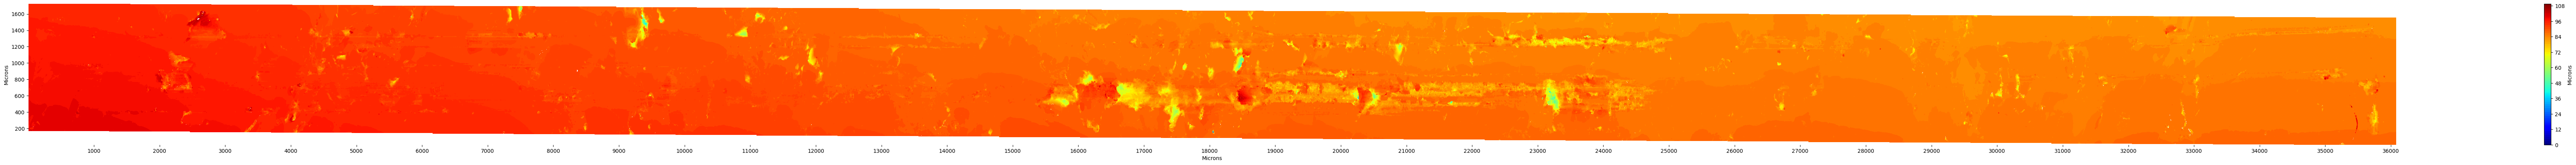

In [373]:
# JBZQ05_10_2_003 = load_wli_data('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/last/JBZQ05_10_1_006.xyz')
# JBZQ05_10_1_006 = load_wli_data('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/last/JBZQ05_10_1_006.xyz')
FLAT_wear1 = load_wli_data('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/last/FLAT_275_2_002.xyz')
# JBZQ05_275_2_007 = load_wli_data('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/last/JBZQ05_275_2_007.xyz')

wear_z, wear_x, wear_y = grid_wli(FLAT_wear1, 1.51968)

# Resolution for lens combinations
# 2.75x, 05 = 5.86782
# 2.75x, 2 = 1.51968

0
0
0
0
0
0
0
0


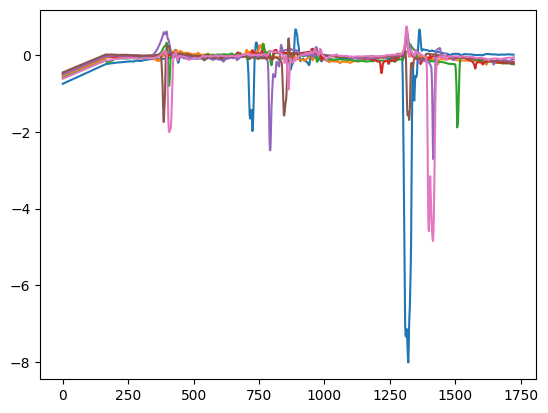

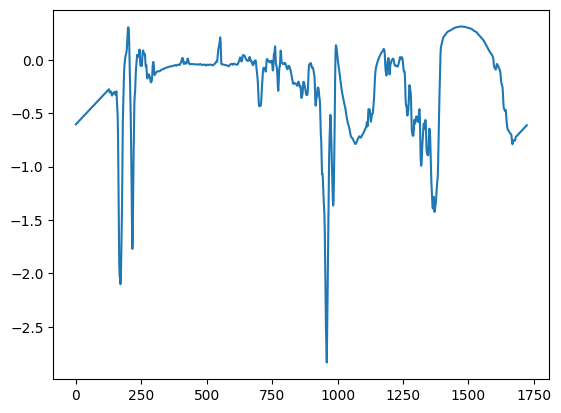

5922.299431459255

In [390]:
# extract the values with wear_x = 1500

def cross_section(row):
    z = wear_z[row]
    y = 1*np.array(wear_y[:-1])

    # fill nan values with interpolation
    z = np.array(pd.Series(z).interpolate(limit_direction='both').tolist())

    # if whole row is nan, copy last interpolated non-nan row (may not be last row)
    if np.all(np.isnan(z)):
        z = np.array(pd.Series(wear_z[row - 1]).interpolate(limit_direction='both').tolist())

    # print number of nans
    print(np.count_nonzero(np.isnan(z)))

    # detrend
    z = signal.detrend(z)

    # temp z
    temp_z = np.copy(z)
    
    temp_z = np.intersect1d(np.where(temp_z > np.percentile(temp_z, 60)), np.where(temp_z < np.percentile(temp_z, 90)))

    # subtract the mean
    z = z - np.mean(z[temp_z])
    
    return z, y

for index in np.arange(int(1000/1.51968), int(2000/1.51968), 100):
    z, y = cross_section(index)
    plt.plot(y, z)
z, y = cross_section(5964)
# plot the values
fig, ax = plt.subplots()
ax.plot(y, z)

plt.show()

# 8500/5.86782

9000/1.51968

0
6708.320169475644 5996.06405524617 712.2561142294744
0
6708.968317367127 6051.060671236196 657.9076461309314
0
10557.440964375475 9860.299002334017 697.1419620414581
0
10614.835546171309 9920.759397363647 694.0761488076623
0
10799.528313496334 10090.363605043747 709.1647084525866
0
10969.064173109964 10242.746184995678 726.317988114286
0
11136.482869212121 10390.766090898062 745.7167783140594
0
11079.347303217897 10322.613097966441 756.7342052514559
0
10554.56257750231 9795.418687543575 759.1438899587356
0
10007.882532704924 9251.192824463058 756.6897082418654
0
9371.774065365318 8618.076479648164 753.6975857171547
0
8488.885109114222 7739.726052712693 749.1590564015296
0
8726.491810344185 7991.068866328511 735.4229440156741
0
8848.330231568774 8144.720765730877 703.609465837897
0
8871.711811541269 8200.468916181064 671.2428953602048
0
8708.065839869192 8070.1705180364515 637.8953218327406
0
8179.540238391975 7576.793464122963 602.7467742690123
0
8637.528946196757 8071.610010306835 5

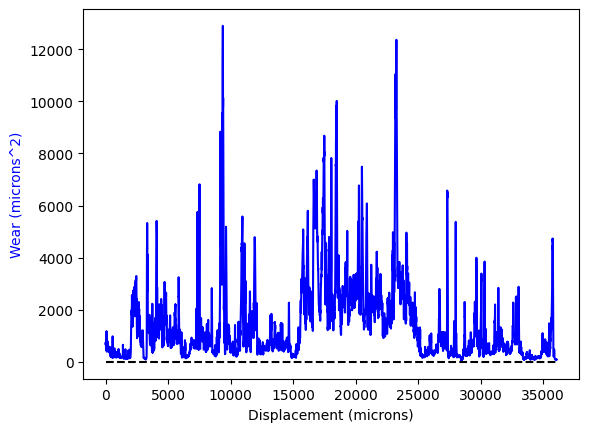

In [375]:
def cross_section_area(y, z):
    # get the nominal area of the cross section
    # area of the trapezoid defined by the first and last points, and the zero line

    # left z value, right z value
    # left_z = np.mean(z[0:20])
    # right_z = np.mean(z[-20:])

    # area_nominal = y[-1] * right_z + (0.5 * abs(right_z - left_z) * y[-1]) # in microns squared

    # area_under_curve = np.trapz(z, y)

    # area_wear = area_nominal - area_under_curve

    # If the array has points above the zero line, make them zero
    z = np.where(z > 0, 0, z)

    # shift the array to be positive
    z = z + abs(min(z))

    # Nominal area of the cross section, the rectangle containing all of the wear
    area_nominal = max(z) * y[-1]

    # Area under the curve, the area of the wear
    area_under_curve = np.trapz(z, y)

    # Area under the curve
    area_wear = area_nominal - area_under_curve

    print(area_nominal, area_under_curve, area_wear)

    return area_wear

areas = []

for i in np.arange(0, len(wear_z), 1):
    z, y = cross_section(i)
    area = cross_section_area(y, z)
    areas.append(area)

print(np.where(areas == max(areas)))

# figure with two y axes
fig, ax1 = plt.subplots()

# ax2 = ax1.twinx()
ax1.plot(wear_x[:-1], areas, 'b-')
ax1.hlines(0, 0, max(wear_x), color='black', linestyle='--')

ax1.set_xlabel('Displacement (microns)')
ax1.set_ylabel('Wear (microns^2)', color='b')
# 
ax1.set_xticks(np.arange(0, max(wear_x), 5000))

plt.show()

# save areas as csv, with x values
areas_df = pd.DataFrame({'x': wear_x[:-1], 'area': areas})
areas_df.to_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/last/FLAT_275_2_002_area.csv', index=False)

In [423]:
# load the csv
areas_df_1 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/last/FLAT_275_2_001_area.csv', skiprows=4869)
areas_df_2 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/last/FLAT_275_05_002_area.csv', skiprows=1448)
areas_df_3 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/last/FLAT_275_2_002_area.csv')

# remove nans
areas_df_1 = areas_df_1.dropna()
areas_df_2 = areas_df_2.dropna()
areas_df_3 = areas_df_3.dropna()


# make header x, z
areas_df_1.columns = ['x', 'area']
areas_df_2.columns = ['x', 'area']
areas_df_3.columns = ['x', 'area']

# make x start at 0
areas_df_1['x'] = areas_df_1['x'] - min(areas_df_1['x'])
areas_df_2['x'] = areas_df_2['x'] - min(areas_df_2['x'])
areas_df_3['x'] = areas_df_3['x'] - min(areas_df_3['x'])

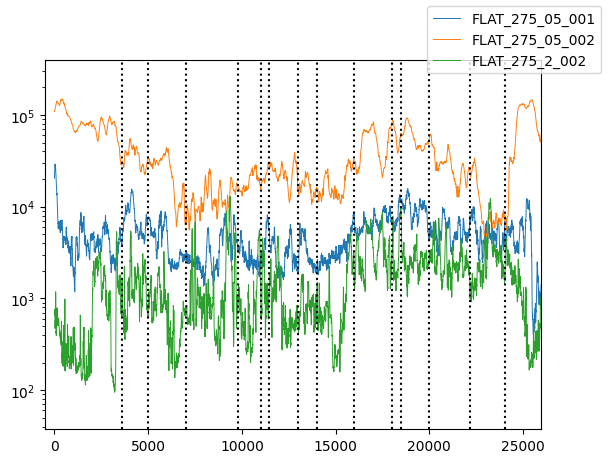

In [424]:
# plot the areas
fig, ax = plt.subplots()

ax.semilogy(areas_df_1['x'], areas_df_1['area'], label='FLAT_275_05_001', linewidth=0.7)
ax.semilogy(areas_df_2['x'], areas_df_2['area'], label='FLAT_275_05_002', linewidth=0.7)
ax.semilogy(areas_df_3['x'], areas_df_3['area'], label='FLAT_275_2_002', linewidth=0.7)
plt.xlim(-500, max(areas_df_1['x']))
# vertical lines at 7300 and 7900

steps = [3600, 5000, 7000, 9800, 11000, 11470, 12980, 14000, 16000, 18000, 18500, 19980, 22160, 24020]
for step in steps:
    plt.axvline(x=step, color='black', linestyle=':')

fig.legend()

### Run this if you dare (will take a long time)

In [17]:
file_list = glob.glob('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/' + '/*.xyz')

for filepath in file_list:
    combined_save(filepath)

[0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03] [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
Saved as \JBZQ05_10_05_001
[0.000e+00 1.000e+00 2.000e+00 ... 2.662e+03 2.663e+03 2.664e+03] [0.000e+00 1.000e+00 2.000e+00 ... 1.027e+03 1.028e+03 1.029e+03]
Saved as t\JBZQ05_10_1_001
[0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03] [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]


            0   0.1   No
0           1     0  NaN
1           2     0  NaN
2           3     0  NaN
3           4     0  NaN
4           5     0  NaN
...       ...   ...  ...
2044751  1986  1026  NaN
2044752  1987  1026  NaN
2044753  1988  1026  NaN
2044754  1989  1026  NaN
2044755  1990  1026  NaN

[2044756 rows x 3 columns]
[0.00000000e+00 1.00100553e+00 2.00201106e+00 ... 1.98899799e+03
 1.98999899e+03 1.99100000e+03] [0.00000000e+00 1.00195312e+00 2.00390625e+00 ... 1.02399609e+03
 1.02499805e+03 1.02600000e+03]


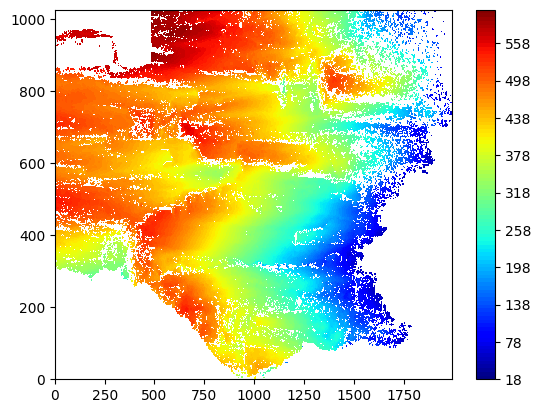

In [16]:
JBZQ05_stitch = load_wli_data('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/JBZQ05_275_05_002.xyz')

grid_wli(JBZQ05_stitch)

In [3]:
jbzq05_10_2_002 = load_wli_data('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/white-light/JBZQ05_10_1_004.xyz')

            1     0         No
0           2     0        NaN
1           3     0        NaN
2           4     0  51621.637
3           5     0        NaN
4           6     0        NaN
...       ...   ...        ...
4896319  2851  1714  51659.773
4896320  2852  1714  51659.462
4896321  2853  1714  51659.083
4896322  2854  1714        NaN
4896323  2855  1714        NaN

[4896324 rows x 3 columns]


[0.000e+00 1.000e+00 2.000e+00 ... 2.853e+03 2.854e+03 2.855e+03] [0.000e+00 1.000e+00 2.000e+00 ... 1.712e+03 1.713e+03 1.714e+03]


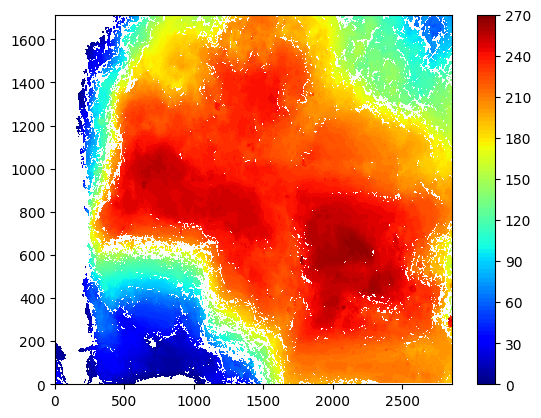

In [6]:
grid_wli(jbzq05_10_2_002)